In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
import numpy as np

class Particle:

    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):

        self.dt = t[1] - t[0]

        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0

        self.m = m
        self.radius = radius
        self.Id = Id

        self.p = self.m*self.v
        self.f = self.m*self.a

        # Historial
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        self.F = np.zeros_like(self.R)
        self.P = np.zeros_like(self.R)

        # Fisica
        self.K = 20.
        self.VEk = np.zeros(len(t))

        # Gravedad
        self.gravity = np.array([0, -9.8])  # Aceleración debida a la gravedad

    def Evolution(self, i):
        self.SetPosition(i)
        self.SetVelocity(i)

        # Actualizar aceleración con la gravedad
        self.a = self.f / self.m + self.gravity

        # Euler-Cromer
        self.v += self.dt * self.a
        self.r += self.dt * self.v

    def CalculateForce(self, p):
        d = np.linalg.norm(self.r - p.r)
        compresion = self.radius + p.radius - d

        if compresion >= 0:
            Fn = self.K * compresion**3
            self.n = (self.r - p.r) / d
            self.f = np.add(self.f, Fn * self.n)
            # Falta implementar energía potencial

    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.

    def SetPosition(self, i):
        self.R[i] = self.r

    def SetVelocity(self, i):
        self.V[i] = self.v
        self.P[i] = self.m * self.v
        self.VEk[i] = 0.5 * self.m * np.dot(self.v, self.v)

    def GetPosition(self, scale=1):
        return self.R[::scale]

    def GetVelocity(self, scale=1):
        return self.V[::scale]

    def GetMomentum(self, scale=1):
        return self.P[::scale]

    def GetKineticEnergy(self, scale=1):
        return self.VEk[::scale]

    def CheckLimits(self):
        for i in range(2):
            if self.r[i] + self.radius > 20 and self.v[i] > 0.:
                self.v[i] = -self.v[i] * 0.9
            elif self.r[i] - self.radius < -20 and self.v[i] < 0.:
                self.v[i] = -self.v[i] * 0.9




In [3]:
def GetParticles(N,t):

    r0 = np.array([-15.,-10.])
    v0 = np.array([2.,0])
    a0 = np.array([0.,0.])

    p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=0)

    Particles = [p0]

    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.

    return Particles

In [4]:
dt = 0.001
tmax = 30
t = np.arange(0,tmax,dt)
Particles = GetParticles(1,t)

In [5]:
def RunSimulation(t,Particles):

    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):

        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])

        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            Particles[i].CheckLimits()
            # Aca debes agregar la interaccion con la pared


    return Particles

In [6]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 30000/30000 [00:00<00:00, 49917.37 Steps/s]


In [7]:
# Bajamos dimensión de la simulacion
scale = 100
t1 = t[::scale]

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


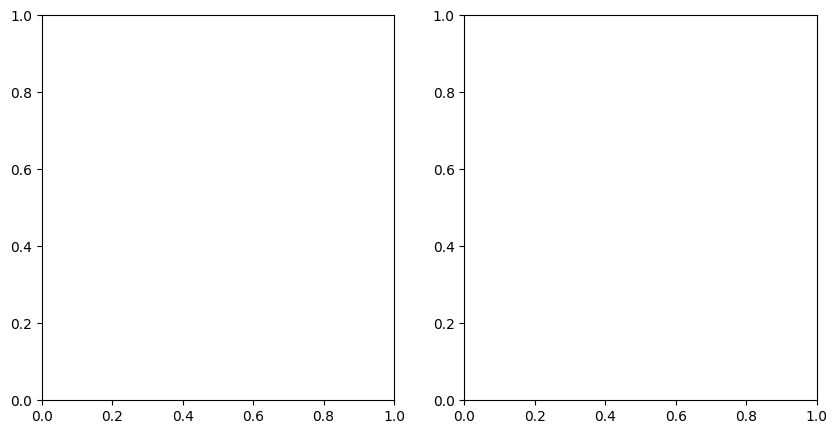

In [17]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


def init():
    ax1.clear()
    ax1.set_xlim(-20, 20)
    ax1.set_ylim(-20, 20)
    ax1.set_title('Particle Animation')


def update(i):
    init()
    ax1.set_title(r'Tiempo: %.3f s' % (t1[i]))

    kinetic_energy = 0

    for particle in Particles:
        x = particle.positions[i, 0]
        y = particle.positions[i, 1]

        vx = particle.velocities[i, 0]
        vy = particle.velocities[i, 1]

        circle = plt.Circle((x, y), particle.radius, color='r', fill=False)
        ax1.add_patch(circle)

        ax1.arrow(x, y, vx, vy, color='k', head_width=0.5, length_includes_head=True)

        kinetic_energy += particle.kinetic_energy[i]

        ax2.set_title('Energía Cinética Total: {:.3f}'.format(kinetic_energy))
        ax2.scatter(t1[:i], particle.kinetic_energy[:i], color='k', marker='.')


animation = anim.FuncAnimation(fig, update, frames=len(t1), init_func=init)

plt.show()

In [10]:
#Animation.save('Rebote.gif', writer='pillow',fps=30)

In [19]:
Mom = Particles[0].GetMomentum(scale)
for i in range(1,len(Particles)):
    Mom = np.add(Mom,Particles[i].GetMomentum(scale))

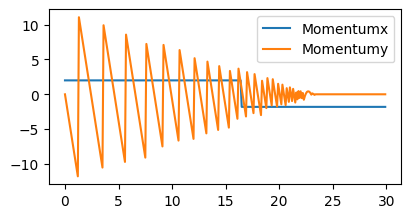

In [24]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax3.plot(t1,Mom[:,0],label='Momentumx')
ax3.plot(t1,Mom[:,1],label='Momentumy')
ax3.legend()

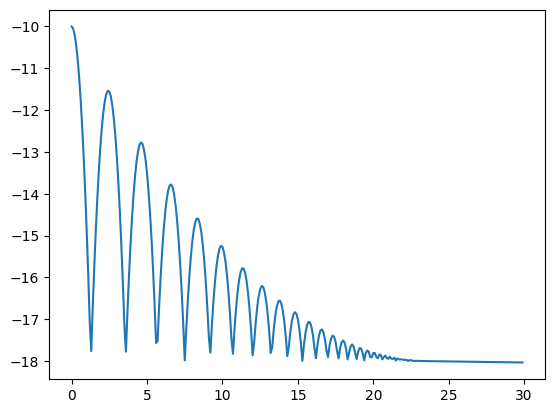

In [13]:
distancia=Particles[0].GetPosition(scale)

plt.plot(t1,distancia[:,1])
plt.show()
#la pelota deja de rebotar después de 23

In [22]:

y = distancia[:, 1]
puntos_maximos = [y[0]]
for i in range(1, len(y) - 1):
    if y[i - 1] < y[i] and y[i + 1] < y[i]:
        puntos_maximos.append(y[i])
        break

amortiguamiento = (puntos_maximos[0] / puntos_maximos[1]) ** 0.5

# Imprimir el resultado
print('El factor de amortiguamiento es aproximadamente: {:.3f}'.format(amortiguamiento))


El factor de amortiguamiento es aproximadamente: 0.931
